In [1]:
# Importing Qiskit and IonQ accounts
from qiskit import IBMQ
from qiskit_ionq import IonQProvider

# Loading your IBM Quantum and IonQ accounts
# IBMQ.save_account('token')
IBMQ.load_account()
ibmq_provider = IBMQ.get_provider('ibm-q')
# ibmq_provider = IBMQ.get_provider('ibm-q-skku','yonsei-uni','yu-students')
# ionq_provider = IonQProvider("")

In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from quantum_walk_simulation import staggered_dsg_circuit_3t

In [3]:
size_degree = 2
shots = 4000

displacement_dict = {"000000001":0, "000000010":1, "000000100":1, 
                     "000001000":9, "000010000":7, "000100000":4,
                     "001000000":9, "010000000":4, "100000000":7}

In [4]:
sys = 'ibmq_qasm_simulator'
sim = ibmq_provider.get_backend(sys)

In [5]:
steps = 300
dt = 0.01
layers = 10
t = np.linspace(dt, steps*dt, steps)
name = f'dsg_3tqw_{steps*dt:.1f}s_{layers:d}ly'

In [6]:
circs = []

# Build a circuit list.
for i in range(steps):
    circs.append(staggered_dsg_circuit_3t(size_degree, t[i], layers, model='Heisenberg'))

# circs[20].draw('mpl')

# Need to transpile the circuits first.
transpiled_circs = transpile(circs, backend=sim, optimization_level=2)

# Use Job Manager to break the circuits into multiple jobs.
job_manager = IBMQJobManager()
job_set = job_manager.run(transpiled_circs, backend=sim, name=sys+'_'+name, shots=shots)

In [7]:
results = job_set.results()
counts_list = list()
for i in range(steps):
    counts_list.append(results.get_counts(i))

In [8]:
msd_temp = 0.
msd_list = list()

for i in range(steps):
    msd_temp = 0.
    for bit, count in counts_list[i].items():
        msd_temp += displacement_dict.get(bit)*count/shots
    msd_list.append(msd_temp)

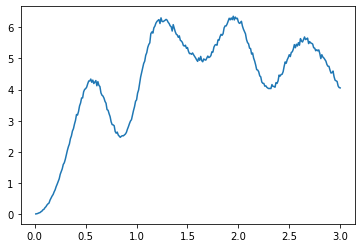

In [9]:
plt.plot(t, msd_list)

In [10]:
import pickle

with open('simulator/'+sys+'_'+name+'_counts_list.pkl','wb') as file :
    pickle.dump(counts_list, file)

In [11]:
import csv

with open('simulator/'+sys+'_'+name+'_msd_list.csv','w') as file :
    write = csv.writer(file)
    write.writerow(msd_list)

In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator

def staggered_dsg_circuit_3t(size_degree: int = 2, t: float = 1., layers: int = 1) -> QuantumCircuit:
    """
    Given size, time t, and the number of steps n, constructs the corresponding staggered quantum walk circuit on DSG.
    Still fixed size_degree at 2
    3 parts of tessellation
    Args:
        size_degree: The degree of DSG (size = 3**size_degree)
        t: Total simulation time
        layers: Number of layers
    Returns:
        QuantumCircuit
    """
    
    size = 3**size_degree
    node_list = np.arange(size)
    theta = np.pi*t/layers
    zeta = complex(np.cos(-2*theta), np.sin(-2*theta))
    
    interaction_2 = Operator([
        [1, 0, 0, 0],
        [0, (zeta+1)/2, (-1*zeta+1)/2, 0],
        [0, (-1*zeta+1)/2, (zeta+1)/2, 0],
        [0, 0, 0, 1]
    ])

    simulation = QuantumCircuit(size, size)

    simulation.x(0)

    for i in range(layers):
        
        simulation.barrier()
        
        # Staggered Quantum Walks tessellation 1
        for j in node_list[::3]:
            a = int(j+(j//3)%3)
            b = int(j+(j//3+1)%3)
            simulation.unitary(interaction_2, [node_list[a], node_list[b]], label='tessel_1')
        for j in node_list[7::9]:
            simulation.unitary(interaction_2, [j, node_list[j-5]], label='tessel_1')
        
        # Staggered Quantum Walks tessellation 2
        for j in node_list[::3]:
            a = int(j+(j//3+2)%3)
            b = int(j+(j//3)%3)
            simulation.unitary(interaction_2, [node_list[a], node_list[b]], label='tessel_2')
        for j in node_list[1::9]:
            simulation.unitary(interaction_2, [j, node_list[j-5]], label='tessel_2')
        
        # Staggered Quantum Walks tessellation 3
        for j in node_list[::3]:
            a = int(j+(j//3+1)%3)
            b = int(j+(j//3+2)%3)
            simulation.unitary(interaction_2, [node_list[a], node_list[b]], label='tessel_3')
        for j in node_list[4::9]:
            simulation.unitary(interaction_2, [j, node_list[j-5]], label='tessel_3')
    
    simulation.barrier()
    
    for i in node_list:
        simulation.measure(i, i)
       
    return simulation

In [3]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [4]:
size_degree = 2
shots = 4000

displacement_dict = {"000000001":0, "000000010":1, "000000100":1, 
                     "000001000":9, "000010000":7, "000100000":4,
                     "001000000":9, "010000000":4, "100000000":7}

In [5]:
sys = 'ibmq_qasm_simulator'
sim = ibmq_provider.get_backend(sys)

In [6]:
steps = 300
dt = 0.01
layers = 10
t = np.linspace(dt, steps*dt, steps)
name = f'dsg_3tqw_{steps*dt:.1f}s_{layers:d}ly'

In [7]:
circs = []

# Build a circuit list.
for i in range(steps):
    circs.append(staggered_dsg_circuit_3t(size_degree, t[i], layers))

# circs[20].draw('mpl')

# Need to transpile the circuits first.
transpiled_circs = transpile(circs, backend=sim, optimization_level=2)

# Use Job Manager to break the circuits into multiple jobs.
job_manager = IBMQJobManager()
job_set = job_manager.run(transpiled_circs, backend=sim, name=sys+'_'+name, shots=shots)

In [8]:
results = job_set.results()
counts_list = list()
for i in range(steps):
    counts_list.append(results.get_counts(i))

In [9]:
msd_temp = 0.
msd_list = list()

for i in range(steps):
    msd_temp = 0.
    for bit, count in counts_list[i].items():
        msd_temp += displacement_dict.get(bit)*count/shots
    msd_list.append(msd_temp)

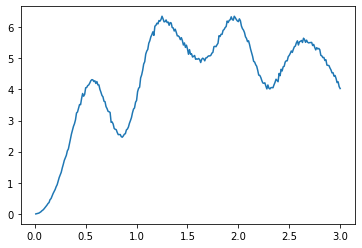

In [10]:
plt.plot(t, msd_list)

In [11]:
import pickle

with open('simulator/'+sys+'_'+name+'_counts_list.pkl','wb') as file :
    pickle.dump(counts_list, file)

In [12]:
import csv

with open('simulator/'+sys+'_'+name+'_msd_list.csv','w') as file :
    write = csv.writer(file)
    write.writerow(msd_list)

In [5]:
sys = 'ibm_hanoi'
backend = ibmq_provider.get_backend(sys)

In [6]:
steps = 300
dt = 0.01
layers = 2
t = np.linspace(dt, steps*dt, steps)
name = f'dsg_3tqw_{steps*dt:.1f}s_{layers:d}ly'

In [7]:
circs = []

# Build a circuit list.
for i in range(steps):
    circs.append(staggered_dsg_circuit_3t(size_degree, t[i], layers))

# Need to transpile the circuits first.
transpiled_circs = transpile(circs, backend=backend, optimization_level=2)

# Use Job Manager to break the circuits into multiple jobs.
job_manager = IBMQJobManager()
job_set = job_manager.run(transpiled_circs, backend=backend, name=sys+'_'+name, shots=shots)

In [8]:
results = job_set.results()
counts_list = list()
for i in range(steps):
    counts_list.append(results.get_counts(i))

In [9]:
msd_list = list()

for i in range(steps):
    valid_count = 0
    for bit, count in counts_list[i].items():
        valid_count += (displacement_dict.get(bit, -1) > -1)*count
    msd_temp = 0.
    for bit, count in counts_list[i].items():
        msd_temp += displacement_dict.get(bit, 0)*count/valid_count
    msd_list.append(msd_temp)

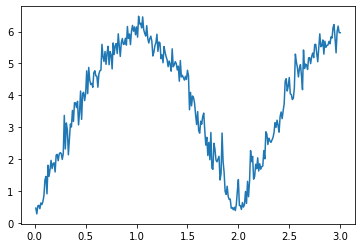

In [10]:
plt.plot(t, msd_list)

In [11]:
import pickle

with open('qpu/'+sys+'_'+name+'_counts_list.pkl','wb') as file :
    pickle.dump(counts_list, file)

In [12]:
import csv

with open('qpu/'+sys+'_'+name+'_msd_list.csv','w') as file :
    write = csv.writer(file)
    write.writerow(msd_list)

In [ ]:
sys = 'ionq_simulator'
backend = ionq_provider.get_backend(sys)

In [ ]:
steps = 300
dt = 0.01
layers = 2
t = np.linspace(dt, steps*dt, steps)
name = f'dsg_3tqw_{steps*dt:.1f}s_{layers:d}ly'

In [25]:
counts_list = list()

for i in range(steps):
    circ = staggered_dsg_circuit_3t(size_degree, t[i], layers)
    transpiled_circ = transpile(circ, backend, optimization_level=2)
    job = backend.run(transpiled_circ, shots=shots)
    results = job.result()
    counts_list.append(results.get_counts())
    if i%10 == 0:
        print(f'in prograss... {i}%')

print(f'complete!      100%')

in prograss... 0%
in prograss... 10%
in prograss... 20%
in prograss... 30%
in prograss... 40%
in prograss... 50%
in prograss... 60%
in prograss... 70%
in prograss... 80%
in prograss... 90%
complete!      100%


In [18]:
msd_temp = 0.
msd_list = list()

for i in range(steps):
    msd_temp = 0.
    for bits, number in counts_list[i].items():
        msd_temp += displacement_dict.get(bits)*number/shots
    msd_list.append(msd_temp)

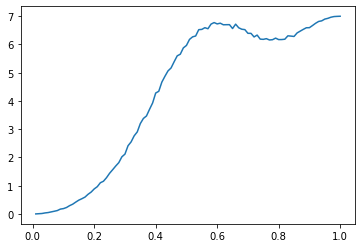

In [26]:
plt.plot(t, msd_list)

In [27]:
import pickle

with open('simulator/'+sys+'_'+name+'_counts_list.pkl','wb') as file :
    pickle.dump(counts_list, file)

In [28]:
import csv

with open('simulator/'+sys+'_'+name+'_msd_list.csv','w') as file :
    write = csv.writer(file)
    write.writerow(msd_list)

In [ ]:
sys = 'ionq_qpu'
backend = ionq_provider.get_backend(sys)

In [ ]:
steps = 60
dt = 0.01
layers = 2
t = np.linspace(dt, steps*dt, steps)
name = f'dsg_3tqw_{steps*dt:.1f}s_{layers:d}ly'

In [ ]:
counts_list = list()

for i in range(steps):
    circ = staggered_dsg_circuit_3t(size_degree, t[i], layers)
    transpiled_circ = transpile(circ, backend, optimization_level=2)
    job = backend.run(transpiled_circ, shots=shots)
    results = job.result()
    counts_list.append(results.get_counts())
    if i%10 == 0:
        print(f'in prograss... {i}%')

print(f'complete!      100%')

In [ ]:
msd_temp = 0.
msd_list = list()

for i in range(steps):
    msd_temp = 0.
    for bits, number in counts_list[i].items():
        msd_temp += displacement_dict.get(bits)*number/shots
    msd_list.append(msd_temp)

In [ ]:
plt.plot(t, msd_list)

In [ ]:
import pickle

with open('qpu/'+sys+'_'+name+'_counts_list.pkl','wb') as file :
    pickle.dump(counts_list, file)

In [ ]:
import csv

with open('qpu/'+sys+'_'+name+'_msd_list.csv','w') as file :
    write = csv.writer(file)
    write.writerow(msd_list)

In [14]:
sys = 'ionq_qpu'
backend = ionq_provider.get_backend(sys)
circ = staggered_dsg_circuit_3t(size_degree, t[45], 1)
transpiled_circ = transpile(circ, backend, optimization_level=2)
job = backend.run(transpiled_circ, shots=shots)
results = job.result()
counts = results.get_counts()

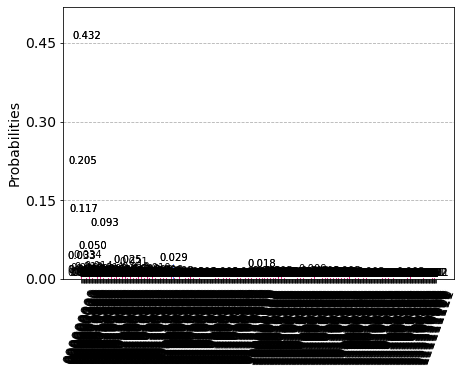

In [15]:
plot_histogram((counts_list[45], counts))